In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [2]:
root = '/Users/n.arai'

In [3]:
torchvision.datasets.FashionMNIST(root, train=True, transform=None, download=False)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /Users/n.arai
    Split: Train

In [4]:
data_transform = transforms.ToTensor()

train_dataset = datasets.FashionMNIST(root="dataset", train=True, transform=data_transform, download=True)

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,shuffle=True)

test_dataset = datasets.FashionMNIST(root="datasets", train=False, transform=data_transform,download=True)

test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100,shuffle=True)

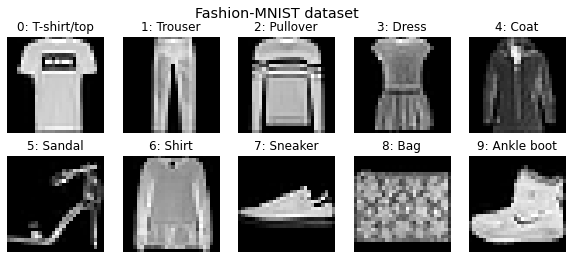

In [5]:
class_ids, sample_indices = np.unique(train_dataset.targets, return_index=True)

fig = plt.figure(figsize=(10, 4))
fig.suptitle("Fashion-MNIST dataset", fontsize="x-large")

for i in class_ids:
    img = train_dataset.data[sample_indices[i]]
    class_name = train_dataset.classes[i]

    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_title(f"{i}: {class_name}")
    ax.set_axis_off()
    ax.imshow(img, cmap="gray")

plt.show()

In [6]:
#クラスに対して画像が何枚あるか可視化->偏りなし
counts = np.bincount(train_dataset.targets)
for i, (count, name) in enumerate(zip(counts, train_dataset.classes)):
    print("{0:25} {1:3}".format(name, count), end='     ')
    if (i + 1) % 3 == 0:
        print()

T-shirt/top               6000     Trouser                   6000     Pullover                  6000     
Dress                     6000     Coat                      6000     Sandal                    6000     
Shirt                     6000     Sneaker                   6000     Bag                       6000     
Ankle boot                6000     

In [7]:
class FashionMNIST_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 10),
        nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x  = self.features(x)
        x =  torch.flatten(x, 1)
        x = self.classifier(x)
            
        return x

In [8]:
nll_loss = nn.NLLLoss()

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FashionMNIST_Model().to(device)

In [10]:
optim = torch.optim.Adam(model.parameters())

In [11]:
def train(model, device, data_loader, optim):
    model.train()
    
    total_loss = 0
    total_correct = 0
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        
        loss = nll_loss(output, target)
        total_loss += float(loss)
        
        optim.zero_grad()
        loss.backward()
        
        optim.step()
        
        pred_target = output.argmax(dim=1)
        
        total_correct += int((pred_target == target).sum())
        
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = total_correct / len(data_loader.dataset)
    
    return avg_loss, accuracy

In [12]:
def test(model, device, data_loader):
    model.eval()
    
    with torch.no_grad():
        total_loss = 0
        total_correct = 0
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            
            loss = nll_loss(output, target)
            total_loss += float(loss)
            
            pred_target = output.argmax(dim=1)
            
            total_correct += int((pred_target == target).sum())
            
            avg_loss = total_loss / len(data_loader.dataset)
            accuracy = total_correct / len(data_loader.dataset)
            
    return avg_loss, accuracy

In [13]:
n_epochs = 50

history = defaultdict(list)
for epoch in range(n_epochs):
    train_loss, train_accuracy = train(model, device, train_data_loader, optim)
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)
    
    test_loss, test_accuracy = test(model, device, test_data_loader)
    history["test_loss"].append(test_loss)
    history["test_accuracy"].append(test_accuracy)
    
    print(
        f"epoch {epoch + 1} "
        f"[train] loss: {train_loss:.6f}, accuracy: {train_accuracy:.0%} "
        f"[test] loss: {test_loss:.6f}, accuracy: {test_accuracy:.0%}"
    )

epoch 1 [train] loss: 0.017972, accuracy: 79% [test] loss: 0.003833, accuracy: 86%
epoch 2 [train] loss: 0.012470, accuracy: 86% [test] loss: 0.003094, accuracy: 88%
epoch 3 [train] loss: 0.010988, accuracy: 87% [test] loss: 0.002849, accuracy: 90%
epoch 4 [train] loss: 0.010013, accuracy: 88% [test] loss: 0.002742, accuracy: 90%
epoch 5 [train] loss: 0.009440, accuracy: 89% [test] loss: 0.002538, accuracy: 91%
epoch 6 [train] loss: 0.008948, accuracy: 90% [test] loss: 0.002521, accuracy: 91%
epoch 7 [train] loss: 0.008613, accuracy: 90% [test] loss: 0.002501, accuracy: 91%
epoch 8 [train] loss: 0.008271, accuracy: 90% [test] loss: 0.002344, accuracy: 92%
epoch 9 [train] loss: 0.008095, accuracy: 90% [test] loss: 0.002323, accuracy: 92%
epoch 10 [train] loss: 0.007838, accuracy: 91% [test] loss: 0.002353, accuracy: 91%
epoch 11 [train] loss: 0.007624, accuracy: 91% [test] loss: 0.002284, accuracy: 92%
epoch 12 [train] loss: 0.007391, accuracy: 91% [test] loss: 0.002274, accuracy: 92%
e

In [14]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [15]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_data_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 84.50%
Accuracy of Trouser: 98.70%
Accuracy of Pullover: 88.70%
Accuracy of Dress: 94.60%
Accuracy of Coat: 91.40%
Accuracy of Sandal: 98.40%
Accuracy of Shirt: 77.10%
Accuracy of Sneaker: 98.50%
Accuracy of Bag: 98.70%
Accuracy of Ankle Boot: 96.60%


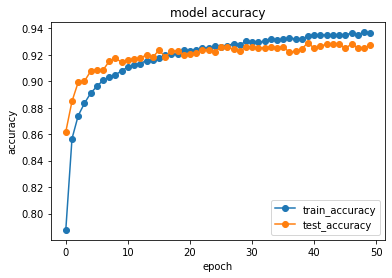

In [16]:
plt.plot(history['train_accuracy'],"o-",label="train_accuracy")
plt.plot(history['test_accuracy'],"o-",label="test_accuracy")
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc="lower right")
plt.show()

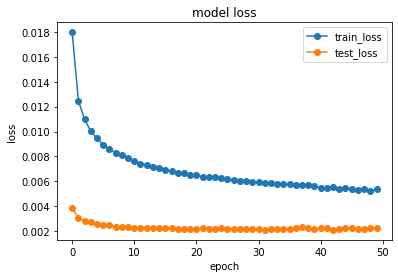

In [21]:
plt.plot(history['train_loss'],"o-",label="train_loss")
plt.plot(history['test_loss'],"o-",label="test_loss")
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper right")
plt.show()